In [154]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import matplotlib.pyplot as plt
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import calc_df, get_photometry, get_colour_distribution
# these are hardcoded in setup_params.py for UVLF calc.
#BoxSize = 25.0
#little_h =  0.6711
#Vcom = BoxSize/little_h

#snaps available:
#snap_044, z=2.00 = 2
#snap_052, z=1.48 = 1.5
#snap_060, z=1.05 = 1
#snap_086, z=0.10 = 0.1

# first things first, lets just read in the hdf5 files to see what they look like.
file_path = "/disk/xray15/aem2/data/28pams/IllTNG/IllustrisTNG_1P_p28_n1_photometry.hdf5"
with h5py.File(file_path, "r") as f:
    
    # Function to recursively print the structure of the HDF5 file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Data Type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
            
    # Use the visititems method to iterate over all groups and datasets in the file
    f.visititems(print_structure)

import h5py

# Open the HDF5 file in read-only mode
file_path = "/disk/xray15/aem2/data/28pams/IllTNG/IllustrisTNG_1P_p16_n1_photometry.hdf5"
with h5py.File(file_path, "r") as hdf:
    lum_UV1500 = hdf["/snap_044/BC03/photometry/luminosity/intrinsic/UV1500"][:]

    # unit error so add units again?
    lum_UV1500_unyt = lum_UV1500 * erg / (Hz * s)
    print(lum_UV1500_unyt)
    abs_mags = [lnu_to_absolute_mag(lum_UV1500_unyt)]
    abs_mag_th = abs_mags[0]
    # next steps, get luminosity function for these magnitudes
    # co-moving volume: BoxSize_025 and redshift:
    Vphys = (BoxSize/little_h )**3
    Vcom = Vphys * ((1+redshift_044)**3)
    print(Vcom)

    phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

    df = pd.DataFrame({
        'phi': phi,
        'phi_sigma': phi_sigma,
        'hist': hist
    })
    df['AGN1']= 0.25

    print(df)

label_025 = 'z = ', redshift_044
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', colour='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution

# vcom and h doesnt need defining as hard coded in uvlf calc in setup_params.py

# specify the path to the photometry file for testing
photo_file = "/disk/xray15/aem2/data/28pams/IllTNG/photometry/IllustrisTNG_1P_p1_0_photometry.hdf5"

# load photometry data with GALEX filters
# see setup_params.py - this returns the AB magnitude in erg/s/Hz
filters = ["GALEX FUV", "GALEX NUV"]
photo_in = get_photometry(
    sim_name="1P_p1_0",
    spec_type="intrinsic",
    snap="086",
    sps="BC03",
    model="IllustrisTNG",
    filters=filters,
    photo_dir=("/disk/xray15/aem2/data/28pams/IllTNG/photometry")
    )

print(photo_in.keys())
# calculate UV luminosity function (UVLF) for FUV and NUV
uvlf_limits = (-24, -16)
nbins=18
phi_FUV_in, phi_sigma_FUV_in, hist_FUV_in, bin_lims_FUV_in = get_luminosity_function(
    photo_in, "GALEX FUV", *uvlf_limits, n_bins=nbins
)
phi_NUV_in, phi_sigma_NUV_in, hist_NUV_in, bin_lims_NUV_in = get_luminosity_function(
    photo_in, "GALEX NUV", *uvlf_limits, n_bins=nbins
)

photo_att = get_photometry(
    sim_name="1P_p1_0",
    spec_type="attenuated",
    snap="0",
    sps="BC03",
    model="IllustrisTNG",
    filters=filters,
    photo_dir=("/disk/xray15/aem2/data/28pams/IllTNG/photometry")
    )

# calculate UV luminosity function (UVLF) for FUV and NUV
phi_FUV_att, phi_sigma_FUV_att, hist_FUV_att, bin_lims_FUV_att = get_luminosity_function(
    photo_att, "GALEX FUV", *uvlf_limits, n_bins=nbins
)
phi_NUV_att, phi_sigma_NUV_att, hist_NUV_att, bin_lims_NUV_att = get_luminosity_function(
    photo_att, "GALEX NUV", *uvlf_limits, n_bins=nbins
)



dict_keys(['GALEX FUV', 'GALEX NUV'])


In [156]:
print(photo_in['GALEX FUV'])


[-19.81150562 -17.07353905 -14.46740957 ... -15.64613201  -8.70392497
  -8.97679498]


In [163]:
photo_in['GALEX FUV'].min()

-21.96054576865304

In [157]:
print(photo_in['GALEX NUV'])


[-20.19437517 -17.59589366 -15.80971859 ... -15.64991915 -11.20159378
 -11.39035799]


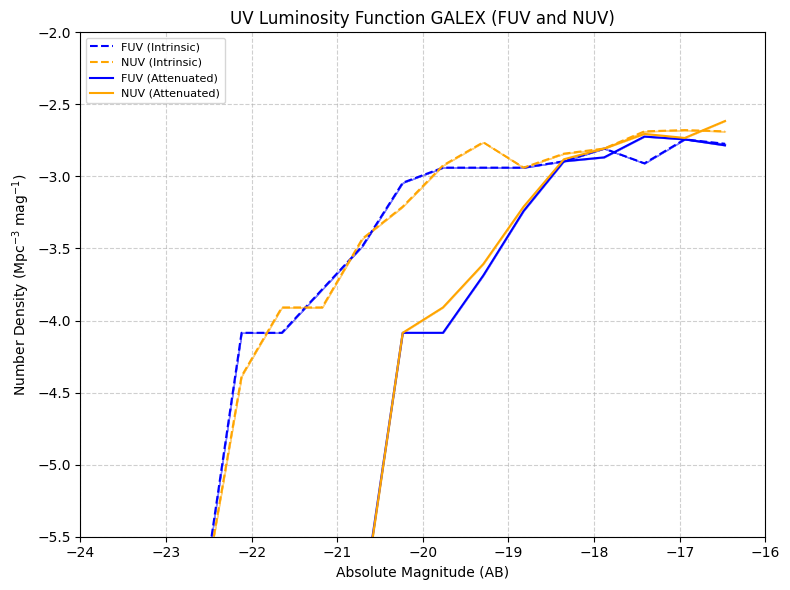

In [161]:
# plot UV luminosity function (UVLF) for GALEX FUV and NUV
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', alpha=0.6)

# INTRINSIC
# plot FUV UVLF
ax.plot(bin_lims_FUV_in[:-1], phi_FUV_in, label="FUV (Intrinsic)", color="blue", ls='--', zorder=2)
ax.fill_between(bin_lims_FUV_in[:-1], 
                phi_FUV_in - phi_sigma_FUV_in, 
                phi_FUV_in + phi_sigma_FUV_in, 
                color="blue", alpha=0.5, zorder=1)

# plot NUV UVLF
ax.plot(bin_lims_NUV_in[:-1], phi_NUV_in, label="NUV (Intrinsic)", color="orange", ls='--', zorder=2)
ax.fill_between(bin_lims_NUV_in[:-1], 
                phi_NUV_in - phi_sigma_NUV_in, 
                phi_NUV_in + phi_sigma_NUV_in, 
                color="orange", alpha=0.5, zorder=1)

# ATTENUATED
# plot FUV UVLF
ax.plot(bin_lims_FUV_att[:-1], phi_FUV_att, label="FUV (Attenuated)", color="blue", ls='-', zorder=2)
ax.fill_between(bin_lims_FUV_att[:-1], 
                phi_FUV_att - phi_sigma_FUV_att, 
                phi_FUV_att + phi_sigma_FUV_att, 
                color="blue", alpha=0.3, zorder=1)

# plot NUV UVLF
ax.plot(bin_lims_NUV_att[:-1], phi_NUV_att, label="NUV (Attenuated)", color="orange", ls='-', zorder=2)
ax.fill_between(bin_lims_NUV_att[:-1], 
                phi_NUV_att - phi_sigma_NUV_att, 
                phi_NUV_att + phi_sigma_NUV_att, 
                color="orange", alpha=0.3, zorder=1)

# set x and y lims
ax.set_xlim(-24,-16)
ax.set_ylim(-5.5,-2)

# add labels and title
ax.set_xlabel('Absolute Magnitude (AB)')
ax.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
ax.legend(loc='upper left', fontsize=8)
ax.set_title("UV Luminosity Function GALEX (FUV and NUV)")

plt.tight_layout()
plt.show()

In [169]:

# magnitude limits (DIS) http://www.galex.caltech.edu/researcher/faq.html
# NUV ~ 25.3 mag
# FUV=25mag
# 
# check the full color range
test_color = photo_in["GALEX FUV"] - photo_in["GALEX NUV"]
print("Full color range in data:")
print(f"Min: {np.min(test_color)}")
print(f"Max: {np.max(test_color)}")



Full color range in data:
Min: -0.37612790767960647
Max: 3.3271137306041894


In [170]:
# magnitude limit mask for fuv
fuv_mask = photo_in["GALEX FUV"] < 25.0  # Only include galaxies brighter than FUV=25
fuv_mask


array([ True,  True,  True, ...,  True,  True,  True])

In [171]:
# magnitude limit mask for nuv
nuv_mask = photo_in["GALEX NUV"] < 25.3  # Only include galaxies brighter than NUV=25.3
nuv_mask


array([ True,  True,  True, ...,  True,  True,  True])

In [172]:
# combine masks - only include galaxies that are bright enough in both bands
combined_mask = fuv_mask & nuv_mask
combined_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [173]:
# show how many galaxies make the cut
print(f"\nTotal galaxies: {len(photo_in['GALEX FUV'])}")
print(f"Galaxies after magnitude cuts: {np.sum(combined_mask)}")



Total galaxies: 1066
Galaxies after magnitude cuts: 1066


In [174]:
#get colour dist for fuv and nuv
 
colour_dist_in, bin_lims_colour_in = get_colour_distribution(
    photo=photo_in,
    filtA="GALEX FUV",
    filtB="GALEX NUV",
    lo_lim=-0.5,
    hi_lim=3.5,
    n_bins=20,
    mask=combined_mask  # Apply our magnitude limit mask
)


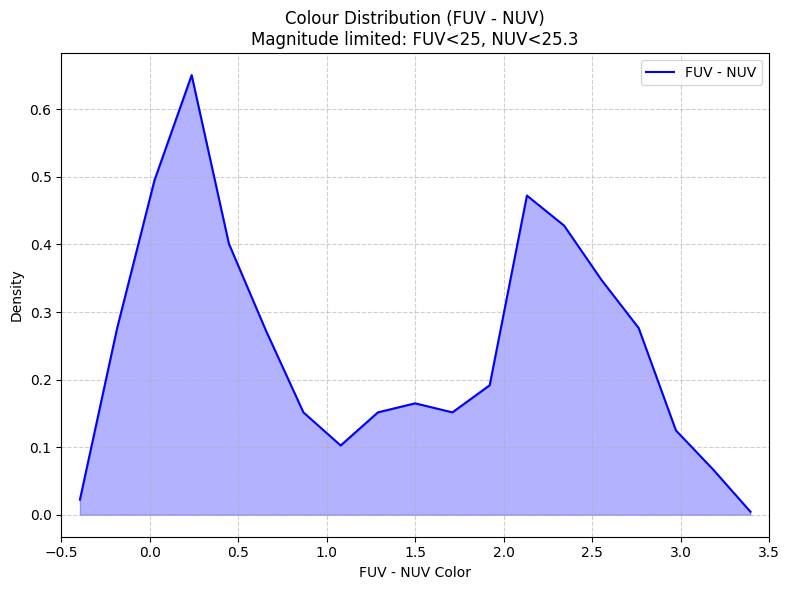

In [175]:
fig, ax = plt.subplots(1, figsize=(8, 6))

# Calculate bin centers for plotting
mid_bins = 0.5 * (bin_lims_colour_in[:-1] + bin_lims_colour_in[1:])

# Plot color distribution
ax.plot(mid_bins, colour_dist_in, label="FUV - NUV", color='blue')
ax.fill_between(mid_bins, np.zeros_like(colour_dist_in), colour_dist_in, 
                alpha=0.3, color='blue')

# Customize plot
ax.set_xlabel("FUV - NUV Color")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Colour Distribution (FUV - NUV)\nMagnitude limited: FUV<25, NUV<25.3")
ax.grid(True, linestyle='--', alpha=0.6)

# Set x-limits based on your actual data range
ax.set_xlim(-0.5, 3.5)

plt.tight_layout()
plt.show()

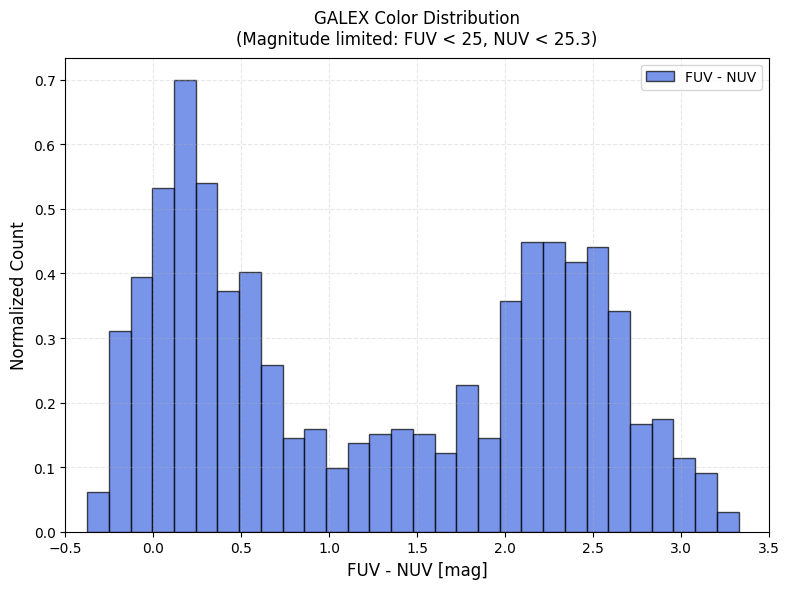

Number of galaxies after magnitude cuts: 1066
Mean color: 1.27
Median color: 1.20


In [176]:
# Create magnitude limit mask
fuv_mask = photo_in["GALEX FUV"] < 25.0  
nuv_mask = photo_in["GALEX NUV"] < 25.3  
combined_mask = fuv_mask & nuv_mask

# Calculate colors for galaxies that meet magnitude limits
colors = photo_in["GALEX FUV"][combined_mask] - photo_in["GALEX NUV"][combined_mask]

# Create plot
fig, ax = plt.subplots(1, figsize=(8, 6))

# Create histogram
ax.hist(colors, bins=30, density=True, alpha=0.7, color='royalblue', 
        edgecolor='black', linewidth=1, label='FUV - NUV')

# Customize plot
ax.set_xlabel('FUV - NUV [mag]', fontsize=12)
ax.set_ylabel('Normalized Count', fontsize=12)
ax.set_title('GALEX Color Distribution\n(Magnitude limited: FUV < 25, NUV < 25.3)', 
             fontsize=12, pad=10)

# Add grid
ax.grid(True, linestyle='--', alpha=0.3)

# Set reasonable x limits based on data
ax.set_xlim(-0.5, 3.5)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of galaxies after magnitude cuts: {len(colors)}")
print(f"Mean color: {np.mean(colors):.2f}")
print(f"Median color: {np.median(colors):.2f}")